In [1]:
from os import listdir
from sys import argv

import numpy as np
# import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve

from sklearn.decomposition import PCA

from skimage import feature
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
from scipy.stats import entropy
from skimage.feature import local_binary_pattern

from sklearn.svm import SVC
from skimage import measure
from skimage.io import imread

import xgboost as xgb

import pandas as pd

from sklearn.preprocessing import minmax_scale as mms
from skimage.util.shape import view_as_blocks
import scipy.stats as stats

from multiprocessing import Pool, Process, Array
import multiprocessing as mp



# Inicialização de alguma variáveis

In [2]:
paths = pd.read_csv('../IC2017_DATA/valid_images.csv')
n_images = len(paths)

names_VI = ["ExG", "ExGR", "CIVE", "VEG", "WI", "NGRDI"]

path_imgs = paths['pic'].values.copy()
path_gts = paths['gt'].values.copy()

n_features = 4 * 6 * 1 # 4 posiçoes, 6 extratores, 1 VI
n_levels = 64 # 4 * 4 * 4 (discretiza em 4 cada canal de cor)

# 1) Declaração de funções (e alguns testes)

In [3]:
mode = lambda a : max(map(lambda val: (a.count(val), val), set(a)))[1]

In [4]:
# normalize = lambda img, a, b : cv2.normalize(img, img, a, b, cv2.NORM_MINMAX, dtype = 1)

## 1.2) BIC

In [5]:
def BIC(image, levels):
    """
    beiradas da imagem devem ser consideradas o que?
    """
    interior = np.zeros(levels, dtype = int)
    borda = np.zeros(levels, dtype = int)
    ns = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    
    lim_lin = image.shape[0]
    lim_col = image.shape[1]

    for lin in range(lim_lin):
        for col in range(lim_col): # laço do elementos da matriz
            curr = image[lin, col]
            interior[curr] += 1
            for n in ns: # laço dos vizinhos
                if lin + n[0] >= 0 and lin + n[0] < lim_lin and col + n[1] >= 0 and col + n[1] < lim_col: # teste de estar dentro da matriz
                    if image[lin + n[0], col + n[1]] != curr:
                        borda[curr] += 1
                        interior[curr] -=1
                        break
                    

    return interior, borda

## 1.3) Haralick

In [6]:
def entropy_func(P):
    return [entropy(P[:, :, 0, i].ravel()) for i in range(P.shape[3])]

In [7]:
def maxProb(P):
    return [np.max(P[:, :, 0, i]) for i in range(P.shape[3])]

In [8]:
def get_features(P):
    """
    Cada medida retorna 4 valores (1 para cada angulo).
    O valor 0 se refere ao fato de escolher sempre a mesma distância.
    """
    contrast = greycoprops(P, prop = "contrast")[0 , :]
    correlation = greycoprops(P, prop = "correlation")[0 , :]
    energy = greycoprops(P, prop = "ASM")[0 , :]
    homogeneity = greycoprops(P, prop = "homogeneity")[0 , :]
    _maxProb = maxProb(P)
    _entropy = entropy_func(P)
    
    #print(contrast, correlation, energy, homogeneity, _maxProb, _entropy)

    return [*contrast, *correlation, *energy, *homogeneity, *_maxProb, *_entropy]

## 1.4) Simple stats

In [9]:
def get_stats(b):
    return [np.min(b),
            np.percentile(b, .25), np.percentile(b, .5), np.percentile(b, .75),
            np.max(b), np.mean(b), np.std(b)]

In [10]:
extractors = ["contrast", "correlation", "energy", "homogeneity", "maxprob", "entropy"]
angles = ["np.pi/4", "0", "3*np.pi/2", "7*np.pi/4"]
statistics = ["min", "q25", "q50", "q75", "max", "mean", "std"]

# GT creation

In [18]:
tri = np.tri(16, 16, dtype='int')
gt_classes = [
    tri,
    tri.T,
    tri[::-1],
    tri.T[::-1],    
]

zer = [np.zeros((16, 16), dtype='int') for _ in range(6)]
zer[0][:, : 8] = 1
zer[1][:, 8 :] = 1
zer[2][: 8, :] = 1
zer[3][8 :, :] = 1
zer[4][:, :] = 1

gt_classes += zer

In [52]:
%%time
"""
Ground Truth (GT) is generated here.
"""

GT = np.zeros((n_images*32*32, ), dtype = "uint8")
for i in range(n_images):
    gt = imread(path_gts[i], as_gray=True)
    _max = np.max(gt)
    _max = _max if _max != 0 else 1
    #print(i, _max)
    gt = gt // _max
    blocks = view_as_blocks(gt, (16,16)).reshape((32*32, 16, 16))
    offset = i*32*32
    for j, b in enumerate(blocks):
        # GT[offset + j] = [(b == c).sum() for c in gt_classes] # 10 regression at once
        GT[offset + j] = np.argmax(np.array([(b == c).sum() for c in gt_classes]))

CPU times: user 2.69 s, sys: 30.2 ms, total: 2.72 s
Wall time: 2.67 s


# Feature Creation Loop

In [21]:
"""
These variables are shared arrays to parallelize the feature creation
"""

sVI = {f : Array("d", (n_images*32*32)*(6*4+7), lock=False) for f in names_VI}
sbic = Array("i", (n_images*32*32)*(n_levels * 2), lock=False)

In [22]:
"""
This function is requied to use the shared variables as global variables in the shared enviroment.
"""

def _init(init_args):
    global tVI
    global tbic
    tVI = init_args[0]
    tbic = init_args[1]

In [35]:
"""
This is the function which generate all block instances (features of 16 x 16 block) of a given image
"""

def worker(args):
    
    i, img_num, path_pic, path_gt = args
    
    def mms(X, a, b):
        _min = X.min()
        _max = X.max()
        X = (X - _min) / (_max - _min) if _min != _max else np.zeros_like(X)
        return X * (b - a) + a 
    
    VI = {f : np.frombuffer(tVI[f]).reshape(n_images*32*32, 6*4+7) for f in names_VI}
    bic = np.frombuffer(tbic, dtype="int32").reshape(n_images*32*32, n_levels * 2)
    
    print(i, end = ' ')
    offset = i*32*32
    pic = imread(path_pic, False)
    
    B, G, R = [np.array(pic[:, :, c], float) for c in range(3)]
    r = R / (R + G + B)
    g = G / (R + G + B)
    b = B / (R + G + B)
    
    
    #VI generation
    F = {} # Imagens Filtradas
    F["ExG"] = 2 * g - r - b
    #print("ExGR")
    F["ExGR"] = F["ExG"] - 1.4 * r - g
    #print("CIVE")
    F["CIVE"] = 0.441 * r - 0.881 * g + 0.385 * b + 18.78745
    #print("VEG")
    divisor = 2 + r ** 0.667 * b ** (1 - 0.667)
    F["VEG"] = np.divide(g, divisor, out=np.zeros_like(divisor), where=divisor!=0)
    #print("WI")
    divisor = r - g
    F["WI"] = np.divide((g - b), divisor, out=np.zeros_like(divisor), where=divisor!=0)
    #print("NGRDI")
    divisor = G + R
    F["NGRDI"] = np.divide((G - R), divisor, out=np.zeros_like(divisor), where=divisor!=0)       
    
    N = {f : mms(F[f], 0, 8 - .001).astype(int) for f in F} # Imagens filtradas Normalizadas
    
    # Haralick
    for f in F:
        blocks = view_as_blocks(N[f], (16,16)).reshape((32*32, 16, 16))
        for j, b in enumerate(blocks):
            # b = np.array(mms(b, (0.5,7.5)) , dtype="uint8") # normaliza apenas o bloco
            P = greycomatrix(b, [1], (np.pi/4, 0, 3*np.pi/2, 7*np.pi/4), 8)
            VI[f][offset + j, :24] = get_features(P)
    
    #"STATS"
    for f in F:
        blocks = view_as_blocks(F[f], (16,16)).reshape((32*32, 16, 16))
        for j, b in enumerate(blocks):
            VI[f][offset + j, 24:] = get_stats(b)
    
    
    #BIC
    bic_pic = sum(mms(pic[:, :, c], 0, 4 - .001).astype(int) * (4**c) for c in range(3))
    blocks = view_as_blocks(bic_pic, (16,16)).reshape((32*32, 16, 16))
    for j, b in enumerate(blocks):
        bic[offset + j, 0:64], bic[b, 64:64*2] = BIC(b, 64)
        
    print("done")
    return i

In [36]:
"""
Define pool of processes
"""
pool = Pool(processes=4, initializer=_init, initargs=([sVI, sbic],))

12 done
4 done
0 done
8 done
13 done
1 done
5 done
9 done
14 done
2 done
6 done
10 done
15 done
7 done
3 done
11 done
16 done
20 done
24 done
28 done
17 done
21 done
25 done
29 done
22 done
18 done
26 done
30 done
23 done
27 done
19 done
31 done
32 done
36 done
40 done
44 done
33 done
37 done
41 done
45 done
34 done
38 done
42 done
46 done
35 done
39 done
43 done
47 done
48 done
52 done
56 done
49 done
53 done
57 done
50 done
54 done
58 done
51 done
55 done


In [37]:
%%time
"""
Execute pool of processes
"""
pool.map(worker, ((
    i,
    paths['num'].iloc[i],
    paths['pic'].iloc[i],
    paths['gt'].iloc[i]
) for i in range(min(n_images, 70))));

CPU times: user 89.5 ms, sys: 42.9 ms, total: 132 ms
Wall time: 1min 13s


In [38]:
"""
Transform shared array structures into numpy variables
"""
VI = {f : np.frombuffer(sVI[f]).reshape(n_images*32*32, 6*4+7) for f in names_VI}
bic = np.frombuffer(sbic, dtype="int32").reshape(n_images*32*32, n_levels * 2)

In [40]:
"""
Generate feature to identify image and block position of each block
"""
IMG = np.zeros(n_images*32*32, dtype="uint8")
BLOCK = np.zeros(n_images*32*32, dtype="uint")
for i in range(n_images):
    IMG[i*32*32:(i+1)*32*32] = paths['num'].iloc[i]
    BLOCK[i*32*32:(i+1)*32*32] = range(32*32)

In [53]:
"""
Generate Pandas dataframe of all data and set column names
"""

data = pd.DataFrame(None, index = range(len(GT)))

for f in names_VI:
    col_names = np.concatenate( [["%s_%s_%s" % (f, ext, ang) for ang in angles] for ext in extractors])
    col_names = np.concatenate([col_names, ["%s_%s" % (f, s) for s in statistics]])
    temp = pd.DataFrame(VI[f], columns=col_names)
    data = pd.concat([data, temp], axis=1)
    
col_names = np.concatenate( [["%s_%d" % (t, i) for i in range(64)] for t in ["interior", "border"]])
temp = pd.DataFrame(bic, columns=col_names)
data = pd.concat([data, temp], axis=1)

data["img_num"] = IMG
data["block_num"] = BLOCK
data["target"] = GT


In [54]:
data['base_num'] = 1
data.loc[data.img_num <= 17, 'base_num'] = 0
data.loc[data.img_num >= 40, 'base_num'] = 2

In [57]:
data.to_csv("../IC2017_DATA/../IC2017_DATA/blocks_simple_MC.csv", index=False)

# Análises

In [128]:
def highlight(ind, color):
    x_ini = (ind % 32) * 16
    x_end = x_ini + 15
    y_ini = (ind // 32) * 16
    y_end = y_ini + 15
    plt.fill_between([x_ini, x_end], y_ini, y_end, alpha =.4, color = color)

In [133]:
i = 3
img = imread(path_imgs[i])
gt = imread(path_gts[i], as_grey=True)

(0, 511)

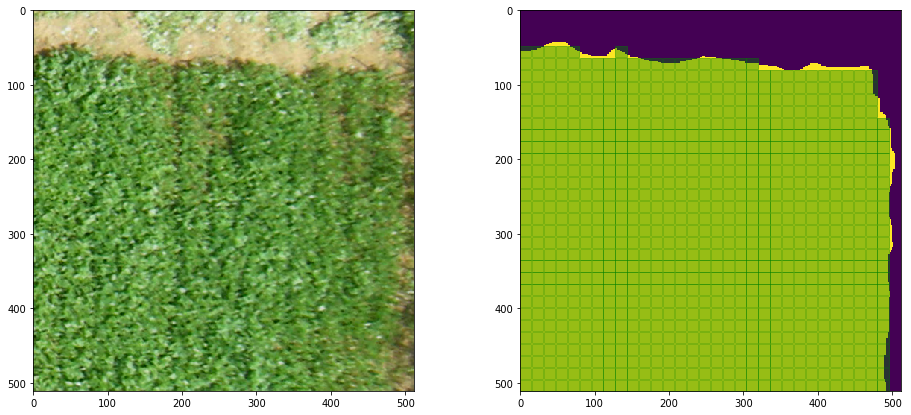

In [134]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.imshow(img)
plt.ylim((511,0))
plt.xlim((0,511))
plt.subplot(1,2,2)
plt.imshow(gt)
for b in BLOCK[(IMG == i) & (GT == 1)]:
    highlight(b, "green")
plt.ylim((511,0))
plt.xlim((0,511))

# Análise das VIs (curva ROC)

Haralick - ExG_contrast_np.pi/4           AUC = 0.831785140873
Haralick - ExG_contrast_0                 AUC = 0.86381203536
Haralick - ExG_contrast_3*np.pi/2         AUC = 0.763053793342
Haralick - ExG_contrast_7*np.pi/4         AUC = 0.855733822839
Haralick - ExG_correlation_np.pi/4        AUC = 0.52294015115
Haralick - ExG_correlation_0              AUC = 0.517550606635
Haralick - ExG_correlation_3*np.pi/2      AUC = 0.565331509402
Haralick - ExG_correlation_7*np.pi/4      AUC = 0.500199247483
Haralick - ExG_energy_np.pi/4             AUC = 0.318777786845
Haralick - ExG_energy_0                   AUC = 0.302827514875
Haralick - ExG_energy_3*np.pi/2           AUC = 0.353869620108
Haralick - ExG_energy_7*np.pi/4           AUC = 0.303602179151
Haralick - ExG_homogeneity_np.pi/4        AUC = 0.205437142352
Haralick - ExG_homogeneity_0              AUC = 0.161560510845
Haralick - ExG_homogeneity_3*np.pi/2      AUC = 0.26917664728
Haralick - ExG_homogeneity_7*np.pi/4      AUC = 0.17415671

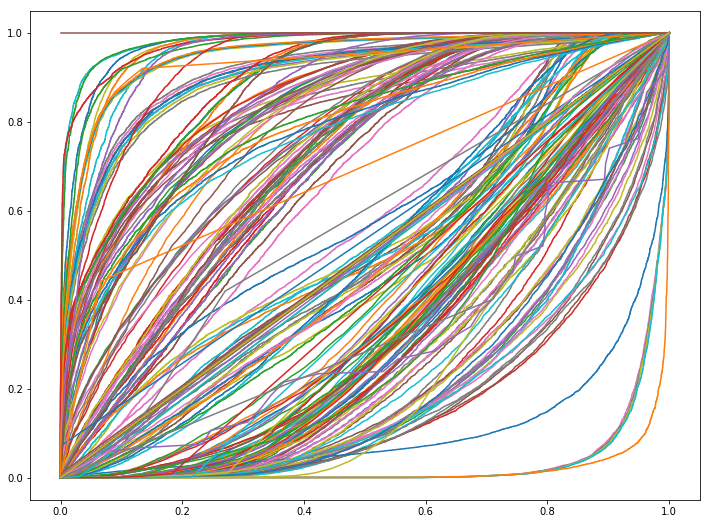

In [79]:
plt.figure(figsize=(12,9))
scores = pd.Series(None, index=data.columns)
for col in data.columns:
    score = roc_auc_score(GT, data[col])
    scores[col] = score
    print("%-30s AUC =" % col, score)
    fpr, tpr = roc_curve(GT, data[col])[:2]
    plt.plot(fpr,tpr)

In [76]:
scores.sort_values(ascending=False)

GT                             1.000000
ExG_mean                       0.983373
VEG_mean                       0.982498
WI_mean                        0.976723
ExGR_mean                      0.973535
WI_max                         0.965431
ExG_max                        0.965313
VEG_max                        0.961844
ExGR_max                       0.954226
WI_q75                         0.951297
WI_q50                         0.949911
WI_q25                         0.948448
WI_min                         0.946773
NGRDI_mean                     0.944817
interior_25                    0.930912
NGRDI_max                      0.928495
ExG_q75                        0.916169
ExG_q50                        0.911447
VEG_q75                        0.907726
ExG_q25                        0.906043
VEG_q50                        0.902533
ExG_min                        0.899774
VEG_q25                        0.896626
VEG_std                        0.893509
VEG_min                        0.889858


In [77]:
scores["IMG"]

0.31653360482481013

# Unificar bases

In [29]:
data1 = pd.read_csv("dataset1.csv")
data2 = pd.read_csv("dataset2.csv")

In [34]:
data2["IMG"] = data2["IMG"] + 40 # talvez não chegue a 40, mas vai ser o bastante

In [35]:
datafull = pd.concat([data1, data2])

In [37]:
datafull.shape

(59392, 319)

In [39]:
datafull.to_csv("datasetfull.csv", index=False)

In [40]:
data2["IMG"]

0        40
1        40
2        40
3        40
4        40
5        40
6        40
7        40
8        40
9        40
10       40
11       40
12       40
13       40
14       40
15       40
16       40
17       40
18       40
19       40
20       40
21       40
22       40
23       40
24       40
25       40
26       40
27       40
28       40
29       40
         ..
22498    61
22499    61
22500    61
22501    61
22502    61
22503    61
22504    61
22505    61
22506    61
22507    61
22508    61
22509    61
22510    61
22511    61
22512    61
22513    61
22514    61
22515    61
22516    61
22517    61
22518    61
22519    61
22520    61
22521    61
22522    61
22523    61
22524    61
22525    61
22526    61
22527    61
Name: IMG, dtype: int64